Training notebook for the deeptail task without data augmentation

In [1]:
import tensorflow
import keras
keras.__version__

Using TensorFlow backend.


'2.1.2'

## Getting started 
- Download data from: https://www.kaggle.com/c/whale-categorization-playground
- Rename train.csv to targets.csv
- Rename the train directory to kaggle_train


In [2]:
import os

home_dir = os.getcwd()
fname = os.path.join(home_dir, 'targets.csv') # targets for both train and validation

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
lines = lines[:-1]

print(header)
print(len(lines))

['Image', 'Id']
9850


# Encoding the whale ids


In [3]:
import numpy as np
whale_ids = [line.split(',')[1] for line in lines]
whale_ids = set(whale_ids) # convert to set to remove duplicats
whale_ids = list(whale_ids) # convert back to list to make it ordered
whale_ids.remove('new_whale') # remove the new_whale since we will not train with this

print(len(whale_ids))

4250


# Preprocessing images

In [4]:
import errno 

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

Split the training images into a train and validation set, and then subdivide them into directories for each whale_id

In [76]:
import shutil
original_dataset_dir = os.path.join(home_dir, 'kaggle_train')

train_dir = os.path.join(home_dir, 'train')
#shutil.rmtree(train_dir)
mkdir_p(train_dir)

validation_dir = os.path.join(home_dir, 'validation')
#shutil.rmtree(validation_dir)
mkdir_p(validation_dir)

# Let's then create a subdirectory for each whale_id in both the train and validation directories 
# so we can use the ImageDataGenerator magic function

classes_count = len(whale_ids) # During the development phase of testing models, we dont look at all 4251 classes. 
                     # When we're ready to look at all classes we can set classes_count = len(whale_ids)

for i, whale_id in enumerate(whale_ids):
    if i < classes_count:
        mkdir_p(os.path.join(train_dir, whale_id))
        mkdir_p(os.path.join(validation_dir, whale_id))

train_image_count = 0

# Copy first 7500 files into the appropriate whale directory in train dir (only if their class is included)   
for i in range(9600):
    pic = lines[i].split(',')[0]
    whale_id = lines[i].split(',')[1]
    src = os.path.join(original_dataset_dir, pic)
    whale_id_dir = os.path.join(train_dir, whale_id)
    if os.path.isdir(whale_id_dir):
        dst = os.path.join(whale_id_dir, pic)
        shutil.copyfile(src, dst)
        train_image_count += 1

validation_image_count = 0
# copy the rest into the appropriate whale directory in validation dir    (only if their class is included)  
for i in range(9600,len(lines)):
    pic = lines[i].split(',')[0]
    whale_id = lines[i].split(',')[1]
    src = os.path.join(original_dataset_dir, pic)
    whale_id_dir = os.path.join(validation_dir, whale_id)
    if os.path.isdir(whale_id_dir):
        dst = os.path.join(whale_id_dir, pic)
        shutil.copyfile(src, dst)
        validation_image_count += 1

print(train_image_count)
print(validation_image_count)

8806
234


### Using a pre-trained convolutional base


In [77]:
from keras.applications import Xception
image_size = (320,320) #adjustable parameter for processed image_size. Run time should 

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(image_size[0], image_size[1], 3))

In [78]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 159, 159, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 159, 159, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 159, 159, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [79]:
ll_size = 10

The final feature map has shape `(ll_size, ll_size, 2048)`. That's the feature on top of which we will stick a densely-connected classifier.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as 
their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [80]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

home_dir = os.getcwd()
train_dir = os.path.join(home_dir, 'train')
validation_dir = os.path.join(home_dir, 'validation')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 100

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, ll_size, ll_size, 2048))
    labels = np.zeros(shape=(sample_count, classes_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=image_size,
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels



In [81]:
train_features, train_labels = extract_features(train_dir, train_image_count)
validation_features, validation_labels = extract_features(validation_dir, validation_image_count)

Found 8806 images belonging to 4250 classes.
Found 234 images belonging to 4250 classes.


In [83]:
train_features = np.reshape(train_features,(train_image_count, ll_size*ll_size*2048))
validation_features = np.reshape(validation_features, (validation_image_count, ll_size*ll_size*2048))

In [68]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=ll_size*ll_size*2048)) # we can play around with 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(classes_count, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 4250)              1092250   
Total params: 52,604,314
Trainable params: 52,604,314
Non-trainable params: 0
_________________________________________________________________


In [47]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=ll_size*ll_size*2048)) # we can play around with 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(classes_count, activation='softmax'))

model.summary()

model.compile(optimizer=optimizers.Adam(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=120,
                    batch_size=100,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/120
8709/8709 [==============================] - 44s 5ms/step - loss: 8.3635 - acc: 0.0021 - val_loss: 8.3454 - val_acc: 0.0000e+00
Epoch 2/120
8709/8709 [==============================] - 31s 4ms/step - loss: 8.3168 - acc: 0.0034 - val_loss: 8.2903 - val_acc: 0.0000e+00
Epoch 3/120
8709/8709 [==============================] - 29s 3ms/step - loss: 8.1954 - acc: 0.0053 - val_loss: 8.2068 - val_acc: 0.0030
Epoch 4/120
8709/8709 [==============================] - 28s 3ms/step - loss: 8.0459 - acc: 0.0048 - val_loss: 8.1465 - val_acc: 0.0000e+00
Epoch 5/120
8709/8709 [==============================] - 29s 3ms/step - loss: 7.8989 - acc: 0.0065 - val_loss: 8.1176 - val_acc: 0.0091
Epoch 6/120
8709/8709 [==============================] - 29s 3ms/step - loss: 7.7768 - acc: 0.0076 - val_loss: 8.0955 - val_acc: 0.0060
Epoch 7/120
8709/8709 [==============================] - 28s 3ms/step - loss: 7.6487 - acc: 0.0093 - val_loss: 8.1016 - val_a

In [48]:
model.save('weights/adam_no_aug_256_0')

In [49]:
model.compile(optimizer=optimizers.Adam(lr=5e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=120,
                    batch_size=150,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/120
8709/8709 [==============================] - 27s 3ms/step - loss: 4.0995 - acc: 0.1701 - val_loss: 11.0364 - val_acc: 0.1208
Epoch 2/120
8709/8709 [==============================] - 24s 3ms/step - loss: 4.1032 - acc: 0.1767 - val_loss: 11.0061 - val_acc: 0.1208
Epoch 3/120
8709/8709 [==============================] - 21s 2ms/step - loss: 4.0807 - acc: 0.1783 - val_loss: 11.0764 - val_acc: 0.1208
Epoch 4/120
8709/8709 [==============================] - 21s 2ms/step - loss: 4.0807 - acc: 0.1729 - val_loss: 10.9869 - val_acc: 0.1148
Epoch 5/120
8709/8709 [==============================] - 25s 3ms/step - loss: 4.0402 - acc: 0.1790 - val_loss: 11.0337 - val_acc: 0.1208
Epoch 6/120
8709/8709 [==============================] - 21s 2ms/step - loss: 4.0822 - acc: 0.1823 - val_loss: 10.9985 - val_acc: 0.1239
Epoch 7/120
8709/8709 [==============================] - 21s 2ms/step - loss: 4.0671 - acc: 0.1812 - val_loss: 10.9989 - val_acc: 0

In [50]:
model.save('weights/adam_no_aug_256_1')

In [51]:
model.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=120,
                    batch_size=150,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/120
8709/8709 [==============================] - 25s 3ms/step - loss: 3.8226 - acc: 0.2071 - val_loss: 11.3482 - val_acc: 0.1329
Epoch 2/120
8709/8709 [==============================] - 21s 2ms/step - loss: 3.8117 - acc: 0.2055 - val_loss: 11.3395 - val_acc: 0.1329
Epoch 3/120
8709/8709 [==============================] - 21s 2ms/step - loss: 3.7992 - acc: 0.2115 - val_loss: 11.3445 - val_acc: 0.1329
Epoch 4/120
8709/8709 [==============================] - 21s 2ms/step - loss: 3.7907 - acc: 0.2099 - val_loss: 11.3540 - val_acc: 0.1329
Epoch 5/120
8709/8709 [==============================] - 24s 3ms/step - loss: 3.8094 - acc: 0.2114 - val_loss: 11.3487 - val_acc: 0.1329
Epoch 6/120
8709/8709 [==============================] - 23s 3ms/step - loss: 3.8327 - acc: 0.2069 - val_loss: 11.3371 - val_acc: 0.1329
Epoch 7/120
8709/8709 [==============================] - 21s 2ms/step - loss: 3.8608 - acc: 0.2022 - val_loss: 11.3589 - val_acc: 0

In [52]:
model.save('weights/adam_no_aug_256_2')

In [53]:
model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=120,
                    batch_size=200,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/120
8709/8709 [==============================] - 26s 3ms/step - loss: 3.7377 - acc: 0.2212 - val_loss: 11.4828 - val_acc: 0.1360
Epoch 2/120
8709/8709 [==============================] - 21s 2ms/step - loss: 3.7649 - acc: 0.2154 - val_loss: 11.4788 - val_acc: 0.1360
Epoch 3/120
8709/8709 [==============================] - 21s 2ms/step - loss: 3.7549 - acc: 0.2187 - val_loss: 11.4935 - val_acc: 0.1329
Epoch 4/120
8709/8709 [==============================] - 21s 2ms/step - loss: 3.7465 - acc: 0.2120 - val_loss: 11.4967 - val_acc: 0.1329
Epoch 5/120
8709/8709 [==============================] - 21s 2ms/step - loss: 3.7491 - acc: 0.2231 - val_loss: 11.4804 - val_acc: 0.1360
Epoch 6/120
8709/8709 [==============================] - 21s 2ms/step - loss: 3.7665 - acc: 0.2123 - val_loss: 11.4833 - val_acc: 0.1329
Epoch 7/120
8709/8709 [==============================] - 21s 2ms/step - loss: 3.7374 - acc: 0.2191 - val_loss: 11.4896 - val_acc: 0

In [54]:
model.save('weights/adam_no_aug_256_3')

In [55]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=ll_size*ll_size*2048)) # we can play around with 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(classes_count, activation='softmax'))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 4250)              1092250   
Total params: 26,782,618
Trainable params: 26,782,618
Non-trainable params: 0
_________________________________________________________________


At an image resolution of 224x224, there are approximately 400,000,000 pixels in our dataset, which is 15x the number of trainable parameters

In [56]:
model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=100,
                    batch_size=64,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/100
8709/8709 [==============================] - 88s 10ms/step - loss: 8.3736 - acc: 0.0021 - val_loss: 8.3402 - val_acc: 0.0030
Epoch 2/100
8709/8709 [==============================] - 66s 8ms/step - loss: 8.2993 - acc: 0.0031 - val_loss: 8.2642 - val_acc: 0.0000e+00
Epoch 3/100
8709/8709 [==============================] - 63s 7ms/step - loss: 8.1281 - acc: 0.0030 - val_loss: 8.1705 - val_acc: 0.0121
Epoch 4/100
8709/8709 [==============================] - 68s 8ms/step - loss: 7.8961 - acc: 0.0063 - val_loss: 8.1336 - val_acc: 0.0121
Epoch 5/100
8709/8709 [==============================] - 61s 7ms/step - loss: 7.6277 - acc: 0.0100 - val_loss: 8.0872 - val_acc: 0.0091
Epoch 6/100
8709/8709 [==============================] - 59s 7ms/step - loss: 7.4292 - acc: 0.0122 - val_loss: 8.1200 - val_acc: 0.0060
Epoch 7/100
8709/8709 [==============================] - 59s 7ms/step - loss: 7.2173 - acc: 0.0181 - val_loss: 8.1304 - val_acc: 0.0

In [57]:
model.save('weights/adam_no_aug_224_more_capacity_0')

In [58]:
model.compile(optimizer=optimizers.Adam(lr=5e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=60,
                    batch_size=128,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/60
8709/8709 [==============================] - 57s 7ms/step - loss: 0.7510 - acc: 0.7941 - val_loss: 10.6160 - val_acc: 0.1782
Epoch 2/60
8709/8709 [==============================] - 46s 5ms/step - loss: 0.7346 - acc: 0.8011 - val_loss: 10.6341 - val_acc: 0.1843
Epoch 3/60
8709/8709 [==============================] - 40s 5ms/step - loss: 0.7039 - acc: 0.8111 - val_loss: 10.6450 - val_acc: 0.1752
Epoch 4/60
8709/8709 [==============================] - 38s 4ms/step - loss: 0.6981 - acc: 0.8087 - val_loss: 10.6417 - val_acc: 0.1813
Epoch 5/60
8709/8709 [==============================] - 40s 5ms/step - loss: 0.7078 - acc: 0.8076 - val_loss: 10.6553 - val_acc: 0.1813
Epoch 6/60
8709/8709 [==============================] - 40s 5ms/step - loss: 0.7159 - acc: 0.8063 - val_loss: 10.6688 - val_acc: 0.1813
Epoch 7/60
8709/8709 [==============================] - 39s 5ms/step - loss: 0.6976 - acc: 0.8130 - val_loss: 10.6742 - val_acc: 0.1752
E

In [59]:
model.save('weights/adam_no_aug_224_more_capacity_1.h5')

#### model.compile(optimizer=optimizers.Adam(lr=4e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=40,
                    batch_size=10,
                    validation_data=(validation_features, validation_labels))

In [28]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=ll_size*ll_size*2048)) # we can play around with 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(classes_count, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               6553728   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 4250)              548250    
Total params: 7,101,978
Trainable params: 7,101,978
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer=optimizers.Adam(lr=3e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=40,
                    batch_size=10,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/40
8709/8709 [==============================] - 92s 11ms/step - loss: 8.3616 - acc: 0.0011 - val_loss: 8.3391 - val_acc: 0.0030
Epoch 2/40
8709/8709 [==============================] - 90s 10ms/step - loss: 8.2282 - acc: 0.0023 - val_loss: 8.2421 - val_acc: 0.0030
Epoch 3/40
8709/8709 [==============================] - 89s 10ms/step - loss: 7.9395 - acc: 0.0064 - val_loss: 8.1974 - val_acc: 0.0030
Epoch 4/40
8709/8709 [==============================] - 89s 10ms/step - loss: 7.6825 - acc: 0.0107 - val_loss: 8.2103 - val_acc: 0.0030
Epoch 5/40
8709/8709 [==============================] - 87s 10ms/step - loss: 7.4089 - acc: 0.0144 - val_loss: 8.1858 - val_acc: 0.0060
Epoch 6/40
8709/8709 [==============================] - 86s 10ms/step - loss: 7.1509 - acc: 0.0189 - val_loss: 8.2826 - val_acc: 0.0091
Epoch 7/40
8709/8709 [==============================] - 87s 10ms/step - loss: 6.9068 - acc: 0.0246 - val_loss: 8.3236 - val_acc: 0.0211
E

In [30]:
history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=10,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/20
8709/8709 [==============================] - 95s 11ms/step - loss: 1.7268 - acc: 0.5811 - val_loss: 9.7642 - val_acc: 0.1662
Epoch 2/20
8709/8709 [==============================] - 95s 11ms/step - loss: 1.6697 - acc: 0.5971 - val_loss: 9.7539 - val_acc: 0.1571
Epoch 3/20
8709/8709 [==============================] - 95s 11ms/step - loss: 1.6292 - acc: 0.6000 - val_loss: 9.8094 - val_acc: 0.1631
Epoch 4/20
8709/8709 [==============================] - 96s 11ms/step - loss: 1.5815 - acc: 0.6189 - val_loss: 9.7721 - val_acc: 0.1541
Epoch 5/20
8709/8709 [==============================] - 96s 11ms/step - loss: 1.5560 - acc: 0.6135 - val_loss: 9.8193 - val_acc: 0.1662
Epoch 6/20
8709/8709 [==============================] - 93s 11ms/step - loss: 1.5082 - acc: 0.6312 - val_loss: 9.8390 - val_acc: 0.1601
Epoch 7/20
8709/8709 [==============================] - 87s 10ms/step - loss: 1.4590 - acc: 0.6372 - val_loss: 9.8015 - val_acc: 0.1662
E

In [31]:
model.save('weights/adam_no_aug_0.h5')

In [32]:
model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=40,
                    batch_size=10,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/40
8709/8709 [==============================] - 90s 10ms/step - loss: 1.0141 - acc: 0.7402 - val_loss: 10.0754 - val_acc: 0.1692
Epoch 2/40
8709/8709 [==============================] - 88s 10ms/step - loss: 0.9889 - acc: 0.7427 - val_loss: 10.0844 - val_acc: 0.1692
Epoch 3/40
8709/8709 [==============================] - 88s 10ms/step - loss: 0.9983 - acc: 0.7438 - val_loss: 10.0576 - val_acc: 0.1601
Epoch 4/40
8709/8709 [==============================] - 87s 10ms/step - loss: 0.9970 - acc: 0.7472 - val_loss: 10.0618 - val_acc: 0.1631
Epoch 5/40
8709/8709 [==============================] - 87s 10ms/step - loss: 0.9859 - acc: 0.7446 - val_loss: 10.0846 - val_acc: 0.1662
Epoch 6/40
8709/8709 [==============================] - 85s 10ms/step - loss: 0.9871 - acc: 0.7477 - val_loss: 10.1097 - val_acc: 0.1631
Epoch 7/40
8709/8709 [==============================] - 92s 11ms/step - loss: 0.9378 - acc: 0.7577 - val_loss: 10.0825 - val_acc: 0

In [33]:
model.save('weights/adam_no_aug_1.h5')

In [35]:

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=ll_size*ll_size*2048)) # we can play around with 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(classes_count, activation='softmax'))


model.compile(optimizer=optimizers.Adam(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=60,
                    batch_size=100,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/60
8709/8709 [==============================] - 18s 2ms/step - loss: 8.3630 - acc: 0.0010 - val_loss: 8.3428 - val_acc: 0.0000e+00
Epoch 2/60
8709/8709 [==============================] - 16s 2ms/step - loss: 8.2793 - acc: 0.0037 - val_loss: 8.2713 - val_acc: 0.0000e+00
Epoch 3/60
8709/8709 [==============================] - 17s 2ms/step - loss: 8.0599 - acc: 0.0052 - val_loss: 8.1640 - val_acc: 0.0000e+00
Epoch 4/60
8709/8709 [==============================] - 16s 2ms/step - loss: 7.8138 - acc: 0.0076 - val_loss: 8.1189 - val_acc: 0.0000e+00
Epoch 5/60
8709/8709 [==============================] - 17s 2ms/step - loss: 7.5859 - acc: 0.0118 - val_loss: 8.0780 - val_acc: 0.0000e+00
Epoch 6/60
8709/8709 [==============================] - 17s 2ms/step - loss: 7.3895 - acc: 0.0134 - val_loss: 8.0721 - val_acc: 0.0030
Epoch 7/60
8709/8709 [==============================] - 17s 2ms/step - loss: 7.1935 - acc: 0.0172 - val_loss: 8.1318 - val_

In [36]:
history = model.fit(train_features, train_labels,
                    epochs=60,
                    batch_size=150,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/60
8709/8709 [==============================] - 14s 2ms/step - loss: 3.7769 - acc: 0.2159 - val_loss: 10.1866 - val_acc: 0.1208
Epoch 2/60
8709/8709 [==============================] - 13s 1ms/step - loss: 3.7765 - acc: 0.2199 - val_loss: 10.1597 - val_acc: 0.1178
Epoch 3/60
8709/8709 [==============================] - 12s 1ms/step - loss: 3.7533 - acc: 0.2226 - val_loss: 10.1429 - val_acc: 0.1239
Epoch 4/60
8709/8709 [==============================] - 12s 1ms/step - loss: 3.7516 - acc: 0.2263 - val_loss: 10.1881 - val_acc: 0.1239
Epoch 5/60
8709/8709 [==============================] - 12s 1ms/step - loss: 3.7241 - acc: 0.2288 - val_loss: 10.2107 - val_acc: 0.1178
Epoch 6/60
8709/8709 [==============================] - 13s 1ms/step - loss: 3.7370 - acc: 0.2259 - val_loss: 10.1592 - val_acc: 0.1239
Epoch 7/60
8709/8709 [==============================] - 13s 1ms/step - loss: 3.6895 - acc: 0.2315 - val_loss: 10.2188 - val_acc: 0.1269
E

In [37]:
history = model.fit(train_features, train_labels,
                    epochs=120,
                    batch_size=300,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/120
8709/8709 [==============================] - 11s 1ms/step - loss: 3.1875 - acc: 0.2941 - val_loss: 10.7829 - val_acc: 0.1511
Epoch 2/120
8709/8709 [==============================] - 10s 1ms/step - loss: 3.1294 - acc: 0.3043 - val_loss: 10.8145 - val_acc: 0.1511
Epoch 3/120
8709/8709 [==============================] - 11s 1ms/step - loss: 3.1288 - acc: 0.2999 - val_loss: 10.7962 - val_acc: 0.1511
Epoch 4/120
8709/8709 [==============================] - 10s 1ms/step - loss: 3.1191 - acc: 0.2993 - val_loss: 10.7327 - val_acc: 0.1511
Epoch 5/120
8709/8709 [==============================] - 10s 1ms/step - loss: 3.1262 - acc: 0.3053 - val_loss: 10.7662 - val_acc: 0.1480
Epoch 6/120
8709/8709 [==============================] - 11s 1ms/step - loss: 3.1112 - acc: 0.3078 - val_loss: 10.7917 - val_acc: 0.1511
Epoch 7/120
8709/8709 [==============================] - 11s 1ms/step - loss: 3.0882 - acc: 0.3083 - val_loss: 10.8035 - val_acc: 0

In [38]:
model.save('weights/adam_no_aug_3.h5')

In [39]:
model.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=60,
                    batch_size=100,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/60
8709/8709 [==============================] - 17s 2ms/step - loss: 2.7807 - acc: 0.3446 - val_loss: 11.4164 - val_acc: 0.1601
Epoch 2/60
8709/8709 [==============================] - 16s 2ms/step - loss: 2.7610 - acc: 0.3522 - val_loss: 11.4262 - val_acc: 0.1631
Epoch 3/60
8709/8709 [==============================] - 16s 2ms/step - loss: 2.7836 - acc: 0.3501 - val_loss: 11.4451 - val_acc: 0.1571
Epoch 4/60
8709/8709 [==============================] - 17s 2ms/step - loss: 2.7363 - acc: 0.3592 - val_loss: 11.4439 - val_acc: 0.1571
Epoch 5/60
8709/8709 [==============================] - 16s 2ms/step - loss: 2.7777 - acc: 0.3457 - val_loss: 11.4170 - val_acc: 0.1601
Epoch 6/60
8709/8709 [==============================] - 16s 2ms/step - loss: 2.7424 - acc: 0.3556 - val_loss: 11.4105 - val_acc: 0.1631
Epoch 7/60
8709/8709 [==============================] - 16s 2ms/step - loss: 2.7372 - acc: 0.3579 - val_loss: 11.4208 - val_acc: 0.1571
E

In [ ]:
history = model.fit(train_features, train_labels,
                    epochs=150,
                    batch_size=10,
                    validation_data=(validation_features, validation_labels))

In [ ]:
model.save('weights/no_aug_2.h5')

In [ ]:
history = model.fit(train_features, train_labels,
                    epochs=150,
                    batch_size=10,
                    validation_data=(validation_features, validation_labels))

In [ ]:
model.save('weights/no_aug_3.h5')

In [30]:
from keras.models import load_model

model = load_model('weights/name_that_whale_702.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               9437312   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4250)              548250    
Total params: 9,985,562
Trainable params: 9,985,562
Non-trainable params: 0
_________________________________________________________________


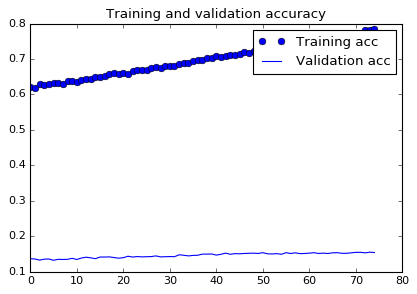

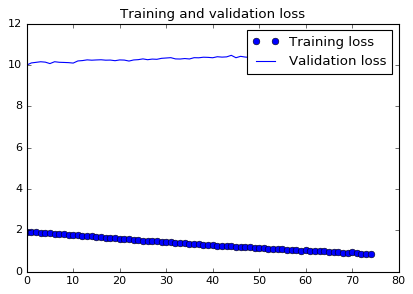

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [62]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=ll_size*ll_size*2048)) # we can play around with 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(classes_count, activation='softmax'))

model.summary()

model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=40,
                    batch_size=64,
                    validation_data=(validation_features, validation_labels))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 4250)              1092250   
Total params: 26,782,618
Trainable params: 26,782,618
Non-trainable params: 0
_________________________________________________________________
Train on 8709 samples, validate on 331 samples
Epoch 1/40
8709/8709 [==============================] - 65s 7ms/step - loss: 8.3765 - acc: 0.0010 - val_loss: 8.3505 - val_acc: 0.0000e+00
Epoch 2/40
8709/8709 [==============================] - 58s 7ms/step - loss: 8.3171 - acc: 0.0041 - val_loss: 8.2974 - val_acc: 0.0000e+00
Epoch 3/40
8709/8709 [==============================] - 57s 7ms/step 

In [63]:
model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/40
8709/8709 [==============================] - 59s 7ms/step - loss: 2.2505 - acc: 0.4813 - val_loss: 9.6514 - val_acc: 0.1541
Epoch 2/40
8709/8709 [==============================] - 34s 4ms/step - loss: 2.1613 - acc: 0.4994 - val_loss: 9.6922 - val_acc: 0.1601
Epoch 3/40
8709/8709 [==============================] - 34s 4ms/step - loss: 2.1599 - acc: 0.5019 - val_loss: 9.7004 - val_acc: 0.1571
Epoch 4/40
8709/8709 [==============================] - 29s 3ms/step - loss: 2.0921 - acc: 0.5202 - val_loss: 9.7176 - val_acc: 0.1601
Epoch 5/40
8709/8709 [==============================] - 29s 3ms/step - loss: 2.0922 - acc: 0.5121 - val_loss: 9.7427 - val_acc: 0.1631
Epoch 6/40
8709/8709 [==============================] - 28s 3ms/step - loss: 2.1124 - acc: 0.5102 - val_loss: 9.7375 - val_acc: 0.1571
Epoch 7/40
8709/8709 [==============================] - 31s 4ms/step - loss: 2.0681 - acc: 0.5218 - val_loss: 9.7347 - val_acc: 0.1662
Epoch 8/

In [84]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=ll_size*ll_size*2048)) # we can play around with 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu', input_dim=ll_size*ll_size*2048))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(classes_count, activation='softmax'))

model.summary()

model.compile(optimizer=optimizers.Adam(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=60,
                    batch_size=64,
                    validation_data=(validation_features, validation_labels))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 512)               104858112 
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 4250)              1092250   
Total params: 106,081,690
Trainable params: 106,081,690
Non-trainable params: 0
_________________________________________________________________
Train on 8806 samples, validate on 234 samples
Epoch 1/60
8806/8806 [==============================] - 293s 33ms/step - loss: 8.

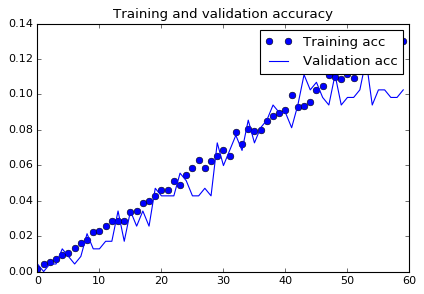

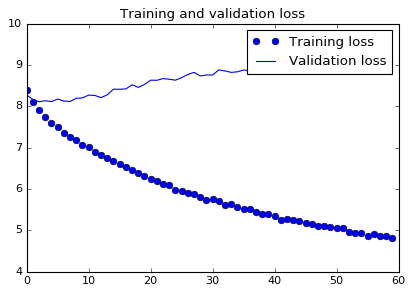

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [86]:
model.compile(optimizer=optimizers.Adam(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=256,
                    validation_data=(validation_features, validation_labels))

Train on 8806 samples, validate on 234 samples
Epoch 1/20
8806/8806 [==============================] - 161s 18ms/step - loss: 4.7952 - acc: 0.1266 - val_loss: 9.1499 - val_acc: 0.1154
Epoch 2/20
8806/8806 [==============================] - 147s 17ms/step - loss: 4.7166 - acc: 0.1443 - val_loss: 9.2087 - val_acc: 0.1154
Epoch 3/20
8806/8806 [==============================] - 148s 17ms/step - loss: 4.6221 - acc: 0.1582 - val_loss: 9.1619 - val_acc: 0.1154
Epoch 4/20
8806/8806 [==============================] - 147s 17ms/step - loss: 4.6580 - acc: 0.1533 - val_loss: 9.2384 - val_acc: 0.1197
Epoch 5/20
8806/8806 [==============================] - 148s 17ms/step - loss: 4.6241 - acc: 0.1538 - val_loss: 9.1910 - val_acc: 0.1197
Epoch 6/20
8806/8806 [==============================] - 148s 17ms/step - loss: 4.5683 - acc: 0.1596 - val_loss: 9.2284 - val_acc: 0.1111
Epoch 7/20
8806/8806 [==============================] - 150s 17ms/step - loss: 4.5917 - acc: 0.1586 - val_loss: 9.2770 - val_acc: 0

KeyboardInterrupt: 

In [89]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(420, activation='relu', input_dim=ll_size*ll_size*2048)) # we can play around with 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(classes_count, activation='softmax'))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 420)               86016420  
_________________________________________________________________
dropout_27 (Dropout)         (None, 420)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 4250)              1789250   
Total params: 87,805,670
Trainable params: 87,805,670
Non-trainable params: 0
_________________________________________________________________


In [90]:
model.compile(optimizer=optimizers.Adam(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=64,
                    validation_data=(validation_features, validation_labels))

Train on 8806 samples, validate on 234 samples
Epoch 1/20
8806/8806 [==============================] - 261s 30ms/step - loss: 8.4007 - acc: 0.0018 - val_loss: 8.3474 - val_acc: 0.0043
Epoch 2/20
8806/8806 [==============================] - 246s 28ms/step - loss: 8.2770 - acc: 0.0047 - val_loss: 8.2871 - val_acc: 0.0043
Epoch 3/20
8806/8806 [==============================] - 246s 28ms/step - loss: 8.0202 - acc: 0.0085 - val_loss: 8.1318 - val_acc: 0.0000e+00
Epoch 4/20
8806/8806 [==============================] - 244s 28ms/step - loss: 7.7649 - acc: 0.0115 - val_loss: 8.1058 - val_acc: 0.0000e+00
Epoch 5/20
8806/8806 [==============================] - 238s 27ms/step - loss: 7.5312 - acc: 0.0179 - val_loss: 8.1027 - val_acc: 0.0085
Epoch 6/20
8806/8806 [==============================] - 243s 28ms/step - loss: 7.3139 - acc: 0.0251 - val_loss: 8.1382 - val_acc: 0.0085
Epoch 7/20
8806/8806 [==============================] - 245s 28ms/step - loss: 7.0849 - acc: 0.0340 - val_loss: 8.0659 - va

In [91]:
history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=64,
                    validation_data=(validation_features, validation_labels))

Train on 8806 samples, validate on 234 samples
Epoch 1/20
8806/8806 [==============================] - 252s 29ms/step - loss: 4.5477 - acc: 0.1906 - val_loss: 9.1145 - val_acc: 0.0897
Epoch 2/20
8806/8806 [==============================] - 253s 29ms/step - loss: 4.3877 - acc: 0.2071 - val_loss: 9.2858 - val_acc: 0.1026
Epoch 3/20
8806/8806 [==============================] - 245s 28ms/step - loss: 4.2962 - acc: 0.2161 - val_loss: 9.2781 - val_acc: 0.1197
Epoch 4/20
8806/8806 [==============================] - 248s 28ms/step - loss: 4.1406 - acc: 0.2309 - val_loss: 9.5330 - val_acc: 0.1111
Epoch 5/20
8806/8806 [==============================] - 248s 28ms/step - loss: 3.9868 - acc: 0.2444 - val_loss: 9.4557 - val_acc: 0.1325
Epoch 6/20
8806/8806 [==============================] - 246s 28ms/step - loss: 3.8773 - acc: 0.2597 - val_loss: 9.4671 - val_acc: 0.1111
Epoch 7/20
8806/8806 [==============================] - 248s 28ms/step - loss: 3.7516 - acc: 0.2757 - val_loss: 9.7191 - val_acc: 0

In [92]:
model.compile(optimizer=optimizers.Adam(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=256,
                    validation_data=(validation_features, validation_labels))

Train on 8806 samples, validate on 234 samples
Epoch 1/20
8806/8806 [==============================] - 144s 16ms/step - loss: 2.5647 - acc: 0.4385 - val_loss: 10.3277 - val_acc: 0.1496
Epoch 2/20
8806/8806 [==============================] - 129s 15ms/step - loss: 2.4416 - acc: 0.4506 - val_loss: 10.3479 - val_acc: 0.1538
Epoch 3/20
8806/8806 [==============================] - 127s 14ms/step - loss: 2.3999 - acc: 0.4575 - val_loss: 10.4116 - val_acc: 0.1581
Epoch 4/20
8806/8806 [==============================] - 126s 14ms/step - loss: 2.3781 - acc: 0.4593 - val_loss: 10.4149 - val_acc: 0.1581
Epoch 5/20
8806/8806 [==============================] - 129s 15ms/step - loss: 2.3249 - acc: 0.4751 - val_loss: 10.3779 - val_acc: 0.1581
Epoch 6/20
8806/8806 [==============================] - 130s 15ms/step - loss: 2.2726 - acc: 0.4799 - val_loss: 10.4966 - val_acc: 0.1496
Epoch 7/20
8806/8806 [==============================] - 131s 15ms/step - loss: 2.1980 - acc: 0.4930 - val_loss: 10.5213 - val

In [93]:
model.save('weights/adam_320_no_aug_0.h5')

In [94]:
history = model.fit(train_features, train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_data=(validation_features, validation_labels))

Train on 8806 samples, validate on 234 samples
Epoch 1/40
8806/8806 [==============================] - 129s 15ms/step - loss: 1.8078 - acc: 0.5700 - val_loss: 10.7942 - val_acc: 0.1667
Epoch 2/40
8806/8806 [==============================] - 109s 12ms/step - loss: 1.7527 - acc: 0.5820 - val_loss: 10.7521 - val_acc: 0.1752
Epoch 3/40
8806/8806 [==============================] - 108s 12ms/step - loss: 1.7501 - acc: 0.5834 - val_loss: 10.7265 - val_acc: 0.1795
Epoch 4/40
8806/8806 [==============================] - 107s 12ms/step - loss: 1.7082 - acc: 0.5905 - val_loss: 10.7730 - val_acc: 0.1709
Epoch 5/40
8806/8806 [==============================] - 109s 12ms/step - loss: 1.6895 - acc: 0.5941 - val_loss: 10.8014 - val_acc: 0.1752
Epoch 6/40
8806/8806 [==============================] - 108s 12ms/step - loss: 1.7006 - acc: 0.5876 - val_loss: 10.7955 - val_acc: 0.1752
Epoch 7/40
8806/8806 [==============================] - 109s 12ms/step - loss: 1.6758 - acc: 0.5974 - val_loss: 10.8277 - val

In [95]:
model.save('weights/adam_320_no_aug_1.h5')